In [2]:
import pandas as pd
import PyPDF2
import re
import fitz
import spacy
import string
import nltk
import torch
import tensorflow as tf
from sklearn.model_selection import ParameterGrid, train_test_split
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import bigrams
from nltk import trigrams
from nltk import ngrams, word_tokenize
from collections import Counter
from rouge import Rouge
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
mpl.rcParams["figure.dpi"] = 96
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
capitulos = {
    
    'CAPÍTULO I': 'Fundamentos del Orden Constitucional',
    'CAPÍTULO II': 'Derechos y Libertades Fundamentales, Garantías y Deberes Constitucionales',
    'CAPÍTULO III': 'Representación Política y Participación',
    'CAPÍTULO IV': 'Congreso Nacional',
    'CAPÍTULO V': 'Gobierno y Administración del Estado',
    'CAPÍTULO VI': 'Defensa Nacional',
    'CAPÍTULO VII': 'Seguridad Pública',
    'CAPÍTULO VIII': 'Gobierno y Administración Regional y Local',
    'CAPÍTULO IX': 'Poder Judicial',
    'CAPÍTULO X': 'Tribunal Constitucional',
    'CAPÍTULO XI': 'Servicio Nacional de Acceso a la Justicia y Defensoría de las Víctimas',
    'CAPÍTULO XII': 'Ministerio Público',
    'CAPÍTULO XIII': 'Justicia Electoral y Servicio Electoral',
    'CAPÍTULO XIV': 'Contraloría General de la República',
    'CAPÍTULO XV': 'Banco Central',
    'CAPÍTULO XVI': 'Protección del Medio Ambiente, Sustentabilidad y Desarrollo',
    'CAPÍTULO XVII': 'Procedimientos de Cambio Constitucional'

}

In [4]:
# Función para extraer texto de archivo pdf
def extract_text_from_pdf(pdf_path, start_page, end_page):
    text = ''
    with fitz.open(pdf_path) as pdf_doc:
        for page_num in range(start_page - 1, end_page):
            page = pdf_doc[page_num]
            text += page.get_text()
    return text

# Función para extraer datos
def extract_data(text):
    chapter_pattern = re.compile(r'CAPÍTULO [IVXLCDM]+')
    article_pattern = re.compile(r'Artículo \d+')
    
    data = []
    current_chapter = None
    current_article = None
    current_text = ''
    
    lines = text.split('\n')
    
    for line in lines:
        # Saltar la línea de encabezado de página
        if line.find('Propuesta Constitución Política de la República de Chile') != -1:
            continue
        
        # Identificar capítulos
        chapter_match = chapter_pattern.match(line)
        if chapter_match:
            # Almacenar datos si hay un artículo anterior
            if current_article is not None and current_text:
                data.append({
                    'capitulo': current_chapter,
                    'articulo': current_article,
                    'texto': current_text.strip()
                })
                current_text = ''
            
            current_chapter = chapter_match.group(0)
            current_article = None
            continue
        
        # Identificar artículos
        article_match = article_pattern.match(line)
        if article_match:
            # Almacenar datos si hay un artículo anterior
            if current_article is not None and current_text:
                data.append({
                    'capitulo': current_chapter,
                    'articulo': current_article,
                    'texto': current_text.strip()
                })
                current_text = ''
            
            current_article = article_match.group(0)
            continue
        
        # Agregar línea al texto actual
        current_text += line.strip() + ' '
    
    # Almacenar el último artículo
    if current_article is not None and current_text:
        data.append({
            'capitulo': current_chapter,
            'articulo': current_article,
            'texto': current_text.strip()
        })
    
    return data

# Función para crear DataFrame
def create_dataframe(data):
    df = pd.DataFrame(data)
    return df

# Configuración archivo entrada
pdf_path = 'constitucion.pdf'
start_page = 7
end_page = 156

# Extracción de texto
pdf_text = extract_text_from_pdf(pdf_path, start_page, end_page)

# Extracción de datos
pdf_data = extract_data(pdf_text)

# Creación del DataFrame
df = create_dataframe(pdf_data)

# Crear la columna 'descripcion_capitulo' utilizando el diccionario 'capitulos'
df['descripcion_capitulo'] = df['capitulo'].map(capitulos)

df

,capitulo,articulo,texto,descripcion_capitulo
0,CAPÍTULO I,Artículo 1,7 FUNDAMENTOS DEL ORDEN CONSTITUCIONAL 1. La d...,Fundamentos del Orden Constitucional
1,CAPÍTULO I,Artículo 2,1. Chile adopta para su gobierno la república ...,Fundamentos del Orden Constitucional
2,CAPÍTULO I,Artículo 3,"1. La Constitución, en tanto norma suprema del...",Fundamentos del Orden Constitucional
3,CAPÍTULO I,Artículo 4,1. El Estado de Chile es unitario y descentral...,Fundamentos del Orden Constitucional
4,CAPÍTULO I,Artículo 5,1. La Constitución reconoce a los pueblos indí...,Fundamentos del Orden Constitucional
...,...,...,...,...
211,CAPÍTULO XVI,Artículo 212,El Estado implementará medidas de mitigación y...,"Protección del Medio Ambiente, Sustentabilidad..."
212,CAPÍTULO XVI,Artículo 213,1. El Estado contará con instituciones adminis...,"Protección del Medio Ambiente, Sustentabilidad..."
213,CAPÍTULO XVII,Artículo 214,PROCEDIMIENTOS DE CAMBIO CONSTITUCIONAL 1. Los...,Procedimientos de Cambio Constitucional
214,CAPÍTULO XVII,Artículo 215,1. El proyecto que aprueben ambas Cámaras pasa...,Procedimientos de Cambio Constitucional


In [5]:
df.texto[0]

'7 FUNDAMENTOS DEL ORDEN CONSTITUCIONAL 1. La dignidad humana es inviolable y la base del derecho y la justicia. Las personas nacen libres e iguales en dignidad y derechos. Su respeto y garantía es el primer deber de la comunidad política y de su forma jurídica de organización. 2. La familia es el núcleo fundamental de la sociedad. Es deber del Estado y la sociedad dar protección a las familias y propender a su fortalecimiento. 3. El Estado de Chile es social y democrático de derecho, que reconoce derechos y libertades fundamentales, deberes constitucionales, y promueve el desarrollo progresivo de los derechos sociales, con sujeción al principio de responsabilidad fiscal y a través de instituciones estatales y privadas. 4. Las agrupaciones que libremente surjan entre las personas gozarán de la adecuada autonomía para cumplir sus fines específicos que no sean contrarios a la Constitución. El Estado respetará los efectos de este reconocimiento. 5. El Estado servirá a las personas y a la 

In [6]:
# Cargar el modelo de spaCy en español
nlp = spacy.load('es_core_news_sm')

# Definir una función para limpiar el texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d', '', str(text))
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace('\n', ' ')
    text = text.strip()
    
    return text

# Definir una función para normalizar el texto
def normalize_text(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if not token.is_stop:
            tokens.append(token.lemma_)
            
    return ' '.join(tokens)

In [7]:
# Aplicar la función de limpieza al texto del dataframe
df['texto_limpio'] = df['texto'].apply(clean_text)

# Aplicar la función de normalización al texto limpio del dataframe
df['texto_normalizado'] = df['texto_limpio'].apply(normalize_text)

df

,capitulo,articulo,texto,descripcion_capitulo,texto_limpio,texto_normalizado
0,CAPÍTULO I,Artículo 1,7 FUNDAMENTOS DEL ORDEN CONSTITUCIONAL 1. La d...,Fundamentos del Orden Constitucional,fundamentos del orden constitucional la digni...,fundamento orden constitucional dignidad hum...
1,CAPÍTULO I,Artículo 2,1. Chile adopta para su gobierno la república ...,Fundamentos del Orden Constitucional,chile adopta para su gobierno la república dem...,chile adopto gobierno república democrática se...
2,CAPÍTULO I,Artículo 3,"1. La Constitución, en tanto norma suprema del...",Fundamentos del Orden Constitucional,la constitución en tanto norma suprema del ord...,constitución norma supremo ordenamiento jurídi...
3,CAPÍTULO I,Artículo 4,1. El Estado de Chile es unitario y descentral...,Fundamentos del Orden Constitucional,el estado de chile es unitario y descentraliza...,chile unitario descentralizado promover desarr...
4,CAPÍTULO I,Artículo 5,1. La Constitución reconoce a los pueblos indí...,Fundamentos del Orden Constitucional,la constitución reconoce a los pueblos indígen...,constitución reconocer pueblo indígena nación ...
...,...,...,...,...,...,...
211,CAPÍTULO XVI,Artículo 212,El Estado implementará medidas de mitigación y...,"Protección del Medio Ambiente, Sustentabilidad...",el estado implementará medidas de mitigación y...,implementar medida mitigación adaptación oport...
212,CAPÍTULO XVI,Artículo 213,1. El Estado contará con instituciones adminis...,"Protección del Medio Ambiente, Sustentabilidad...",el estado contará con instituciones administra...,contar institución administrativo jurisdiccion...
213,CAPÍTULO XVII,Artículo 214,PROCEDIMIENTOS DE CAMBIO CONSTITUCIONAL 1. Los...,Procedimientos de Cambio Constitucional,procedimientos de cambio constitucional los p...,procedimiento cambio constitucional proyecto...
214,CAPÍTULO XVII,Artículo 215,1. El proyecto que aprueben ambas Cámaras pasa...,Procedimientos de Cambio Constitucional,el proyecto que aprueben ambas cámaras pasará ...,proyecto apruebir ambos cámara pasar president...


In [8]:
# Visualización del segundo artículo con preprocesamiento.

df.texto_limpio[1]

'chile adopta para su gobierno la república democrática con separación de poderes y régimen presidencial la soberanía reside en el pueblo de chile nación única e indivisible y se ejerce por este a través de elecciones periódicas plebiscitos y mecanismos de participación y también por las autoridades que esta constitución establece ningún sector del pueblo persona institución o grupo puede atribuirse su ejercicio  la ley asegurará el acceso equilibrado de mujeres y hombres a las candidaturas a cargos de elección popular así como su participación en condiciones de igualdad en los distintos ámbitos de la vida nacional el estado garantizará el ejercicio de la participación política de las mujeres'

In [9]:
df.texto_normalizado[1]

'chile adopto gobierno república democrática separación poder régimen presidencial soberanía residir pueblo chile nación único indivisible ejercer elección periódico plebiscito mecanismo participación autoridad constitución establecer sector pueblo persón institución grupo atribuir él ejercicio   ley asegurar acceso equilibrado mujer hombre candidatura cargo elección popular participación condición igualdad distinto ámbito vida nacional garantizar ejercicio participación político mujer'

In [10]:
# Calcular algunas estadísticas descriptivas del texto

n_capitulos = df['capitulo'].nunique()
print(f'El texto tiene {n_capitulos} capítulos.')

n_articulos = df['articulo'].nunique()
print(f'El texto tiene {n_articulos} artículos.')

df['n_palabras'] = df['texto'].apply(lambda x: len(word_tokenize(x)))
n_palabras = df['n_palabras'].sum()
print(f'El texto tiene {n_palabras} palabras.')

df['n_caracteres'] = df['texto'].apply(lambda x: len(x))
n_caracteres = df['n_caracteres'].sum()
print(f'El texto tiene {n_caracteres} caracteres.')

df['n_unicas'] = df['texto'].apply(lambda x: len(set(word_tokenize(x))))
n_unicas = df['n_unicas'].sum()
print(f'El texto tiene {n_unicas} palabras únicas.')

El texto tiene 17 capítulos.
El texto tiene 216 artículos.
El texto tiene 48528 palabras.
El texto tiene 277434 caracteres.
El texto tiene 22388 palabras únicas.


In [11]:
# Número de palabras por cada capítulo

top_capitulos = df.groupby(['capitulo'])['n_palabras'].sum()
top_capitulos = top_capitulos.sort_values(ascending=False).reset_index()
top_capitulos

,capitulo,n_palabras
0,CAPÍTULO II,11095
1,CAPÍTULO IV,9649
2,CAPÍTULO V,4559
3,CAPÍTULO VIII,4482
4,CAPÍTULO X,3183
5,CAPÍTULO IX,3130
6,CAPÍTULO XII,2071
7,CAPÍTULO I,2036
8,CAPÍTULO III,1922
9,CAPÍTULO XIII,1478


In [12]:
# Número de palabras por cada capítulo

top_desc_capitulos = df.groupby(['descripcion_capitulo'])['n_palabras'].sum()
top_desc_capitulos = top_desc_capitulos.sort_values(ascending=False).reset_index()
top_desc_capitulos

,descripcion_capitulo,n_palabras
0,"Derechos y Libertades Fundamentales, Garantías...",11095
1,Congreso Nacional,9649
2,Gobierno y Administración del Estado,4559
3,Gobierno y Administración Regional y Local,4482
4,Tribunal Constitucional,3183
5,Poder Judicial,3130
6,Ministerio Público,2071
7,Fundamentos del Orden Constitucional,2036
8,Representación Política y Participación,1922
9,Justicia Electoral y Servicio Electoral,1478


In [13]:
# Número de artículos por cada capítulo

count_articulos = df.groupby('descripcion_capitulo').agg(n_articulos=('articulo', 'size'))
count_articulos = count_articulos.sort_values(by='n_articulos', ascending=False).reset_index()
count_articulos

,descripcion_capitulo,n_articulos
0,Congreso Nacional,39
1,Gobierno y Administración Regional y Local,29
2,Gobierno y Administración del Estado,24
3,"Derechos y Libertades Fundamentales, Garantías...",22
4,Fundamentos del Orden Constitucional,15
5,Representación Política y Participación,13
6,Ministerio Público,13
7,Poder Judicial,13
8,Seguridad Pública,9
9,Banco Central,8


In [14]:
# Artículos con mayor cantidad de palabras

top_articulos = df.groupby(['articulo'])['n_palabras'].sum()
top_articulos = top_articulos.sort_values(ascending=False).reset_index()
top_articulos.head(10)

,articulo,n_palabras
0,Artículo 16,7519
1,Artículo 172,1779
2,Artículo 57,1073
3,Artículo 100,894
4,Artículo 190,784
5,Artículo 59,767
6,Artículo 162,741
7,Artículo 58,682
8,Artículo 69,654
9,Artículo 74,626


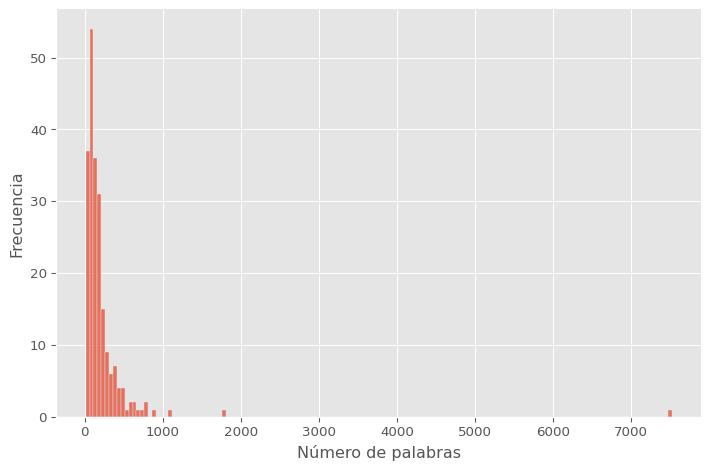

In [15]:
# Histograma del número de palabras por artículo

sns.displot(df, x='n_palabras', bins=150, fill=True, height=5, aspect=1.5)
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show();

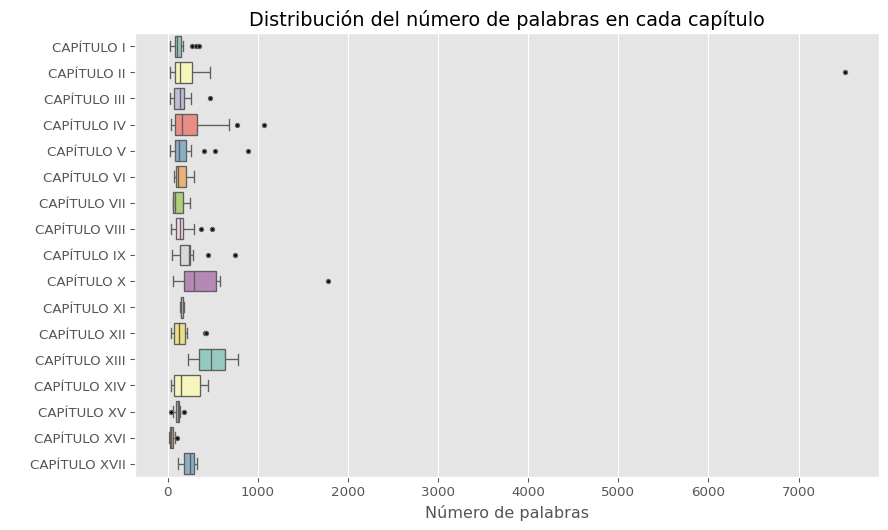

In [16]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(10, 6))

# Configuración del gráfico de cajas
sns.boxplot(data=df, y='capitulo', x='n_palabras', hue='capitulo', palette='Set3', dodge=False,
            fliersize=3, flierprops={'color': 'black', 'markerfacecolor': 'black'})

# Etiquetas y mostrar el gráfico
plt.xlabel('Número de palabras')
plt.title('Distribución del número de palabras en cada capítulo')
plt.ylabel(' ')
plt.show();

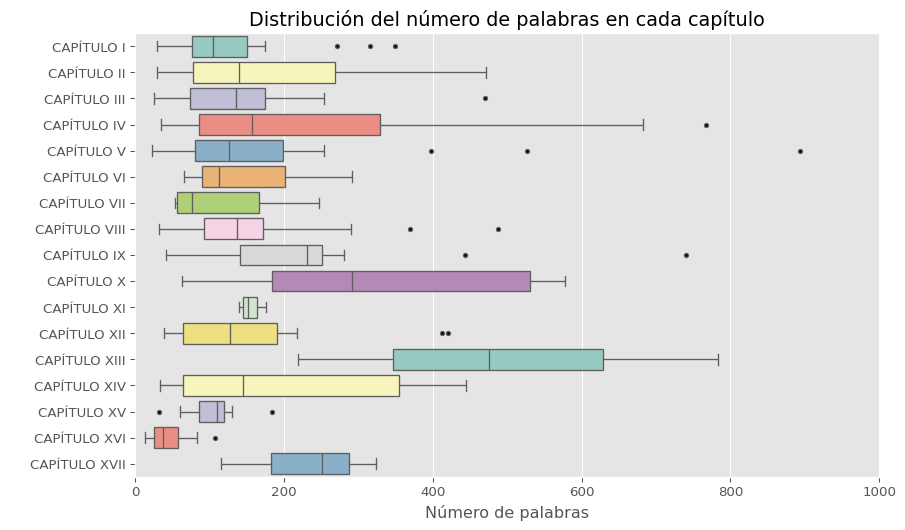

In [17]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(10, 6))

# Configuración del gráfico de cajas
sns.boxplot(data=df, y='capitulo', x='n_palabras', hue='capitulo', palette='Set3', dodge=False,
            fliersize=3, flierprops={'color': 'black', 'markerfacecolor': 'black'})

# Establecer el límite del eje x hasta 1000 palabras
plt.xlim(0, 1000)

# Etiquetas y mostrar el gráfico
plt.xlabel('Número de palabras')
plt.title('Distribución del número de palabras en cada capítulo')
plt.ylabel(' ')
plt.show();

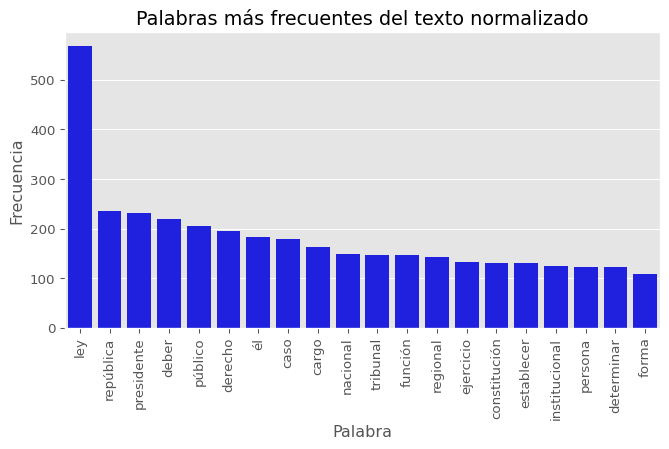

In [18]:
# Gráfico de barras de las palabras más frecuentes del texto normalizado

plt.figure(figsize=(8, 4))
freq = nltk.FreqDist(word_tokenize(' '.join(df['texto_normalizado'])))
freq_df = pd.DataFrame(freq.most_common(20), columns=['Palabra', 'Frecuencia'])
sns.barplot(data=freq_df, x='Palabra', y='Frecuencia', color='blue')
plt.xticks(rotation=90)
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes del texto normalizado')
plt.show();

In [16]:
# Se configura stopwords
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop + ['ser','tener','deber', 'día', 'si']

def lemmatizer(text):  
    doc = nlp(text)
    return ' '.join([word.lemma_ for word in doc if word.lemma_ not in esp_stop])

# Se crea una lista de textos lematizados
texts = [[word for word in word_tokenize(lemmatizer(clean_text(text))) if word not in esp_stop] for text in df['texto']]

# Se crea un diccionario de términos
dictionary = Dictionary(texts)

# Se crea una representación de bolsa de palabras (BoW) del corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Se crea una representación TF-IDF del corpus
tfidf_model = TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

# Entrenar el modelo LDA con TF-IDF inicialmente con 5 tópicos
lda_model_tfidf = LdaModel(corpus_tfidf, num_topics=5, id2word=dictionary, passes=15, random_state=25)

# Imprimir los temas identificados
for idx, topic in lda_model_tfidf.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# Asignar temas a los documentos en el DataFrame original con TF-IDF
df['temas_lda_tfidf'] = [lda_model_tfidf[dictionary.doc2bow(text)] for text in texts]

df.head()

Topic 0: 0.001*"penal" + 0.001*"debate" + 0.001*"sustentabilidad" + 0.001*"definir" + 0.001*"senatorial" + 0.001*"orientar" + 0.001*"obligar" + 0.001*"atribuir" + 0.001*"protección" + 0.001*"acordarir"
Topic 1: 0.002*"tratado" + 0.002*"contraloría" + 0.002*"desarrollo" + 0.002*"internacional" + 0.002*"unidad" + 0.002*"cuenta" + 0.001*"ratificado" + 0.001*"reconocer" + 0.001*"sociedad" + 0.001*"fundamental"
Topic 2: 0.002*"electo" + 0.001*"gobernador" + 0.001*"emitido" + 0.001*"flagrante" + 0.001*"protección" + 0.001*"diputado" + 0.001*"sustentabilidad" + 0.001*"elección" + 0.001*"ambiente" + 0.001*"medio"
Topic 3: 0.001*"apropiado" + 0.001*"niño" + 0.001*"particular" + 0.001*"rendir" + 0.001*"emblema" + 0.001*"mutuo" + 0.001*"medida" + 0.001*"ambiente" + 0.001*"discapacidad" + 0.001*"dispongar"
Topic 4: 0.004*"presidente" + 0.004*"fiscal" + 0.004*"regional" + 0.004*"república" + 0.003*"público" + 0.003*"cargo" + 0.003*"poder" + 0.003*"tribunal" + 0.003*"electoral" + 0.003*"nacional"


,capitulo,articulo,texto,descripcion_capitulo,texto_limpio,texto_normalizado,n_palabras,n_caracteres,n_unicas,temas_lda_tfidf
0,CAPÍTULO I,Artículo 1,7 FUNDAMENTOS DEL ORDEN CONSTITUCIONAL 1. La d...,Fundamentos del Orden Constitucional,fundamentos del orden constitucional la digni...,fundamento orden constitucional dignidad hum...,271,1517,140,"[(1, 0.43615633), (4, 0.5584327)]"
1,CAPÍTULO I,Artículo 2,1. Chile adopta para su gobierno la república ...,Fundamentos del Orden Constitucional,chile adopta para su gobierno la república dem...,chile adopto gobierno república democrática se...,127,719,80,"[(0, 0.15744813), (4, 0.83228296)]"
2,CAPÍTULO I,Artículo 3,"1. La Constitución, en tanto norma suprema del...",Fundamentos del Orden Constitucional,la constitución en tanto norma suprema del ord...,constitución norma supremo ordenamiento jurídi...,174,1083,101,"[(1, 0.38796175), (4, 0.6046019)]"
3,CAPÍTULO I,Artículo 4,1. El Estado de Chile es unitario y descentral...,Fundamentos del Orden Constitucional,el estado de chile es unitario y descentraliza...,chile unitario descentralizado promover desarr...,120,722,74,"[(1, 0.2484348), (4, 0.73999137)]"
4,CAPÍTULO I,Artículo 5,1. La Constitución reconoce a los pueblos indí...,Fundamentos del Orden Constitucional,la constitución reconoce a los pueblos indígen...,constitución reconocer pueblo indígena nación ...,105,631,69,"[(1, 0.31086048), (2, 0.22099386), (4, 0.45955..."


Una interpretación a los tópicos encontrados puede ser el siguiente:

Topic 0: Este tema se centra en asuntos abordados en el CAPÍTULO II, que trata sobre los derechos y libertades fundamentales, garantías y deberes constitucionales. También presenta conexiones con el CAPÍTULO XVI, que trata sobre la protección del medio ambiente, sustentabilidad y desarrollo. Las palabras clave incluyen penal, debate, sustentabilidad, definir, senatorial, orientar, obligar, atribuir, protección y acordar.

Topic 1: Este tema se relaciona principalmente con el CAPÍTULO XVII sobre procedimientos de cambio constitucional y, en parte, con el CAPÍTULO XIV, que aborda la contraloría general de la república. Las palabras clave en este contexto son tratado, contraloría, desarrollo, internacional, unidad, cuenta, ratificado, reconocer, sociedad y fundamental.

Topic 2: Aquí, el foco está en el CAPÍTULO VIII, que trata sobre el gobierno y la administración regional y local, y también en el CAPÍTULO III, que se refiere a la representación política y participación. Las palabras clave que resaltan este tema son electo, gobernador, emitido, flagrante, protección, diputado, sustentabilidad, elección, ambiente y medio.

Topic 3: Este tema parece estar vinculado con el CAPÍTULO XII, que aborda el ministerio público, y con el CAPÍTULO XI, relacionado con el servicio nacional de acceso a la justicia y la defensoría de las víctimas. Las palabras clave incluyen apropiado, niño, particular, rendir, emblema, mutuo, medida, ambiente, discapacidad y disponer.

Topic 4: En este tema, se destaca el CAPÍTULO XIII de la justicia electoral y el servicio electoral, así como el CAPÍTULO V del gobierno y la administración del estado. Las palabras clave que caracterizan este tema son presidente, fiscal, regional, república, público, cargo, poder, tribunal, electoral y nacional.

A continuación, se evaluará la coherencia del modelo LDA con TF-IDF para diferentes números de tópicos y se graficarán los resultados. Para determinar el número óptimo de tópicos que maximiza la coherencia del modelo, se continuará con la puntuación de coherencia más alta, lo cual indica una mejor interpretación de los tópicos.

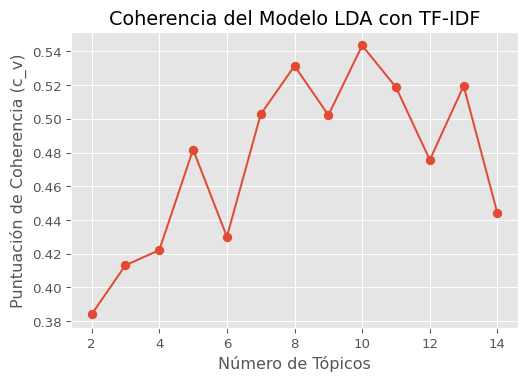

In [17]:
# Se crea un diccionario de términos
dictionary = Dictionary(texts)

# Se calcula la coherencia para diferentes números de tópicos
coherence_scores = []
num_topics_list = range(2, 15)

for num_topics in num_topics_list:
    lda_model = LdaModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=15, random_state=25)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Graficar los resultados
plt.figure(figsize=(6, 4))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.title('Coherencia del Modelo LDA con TF-IDF')
plt.xlabel('Número de Tópicos')
plt.ylabel('Puntuación de Coherencia (c_v)')
plt.show();

In [18]:
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4817456882704289


In [19]:
# Entrenar el modelo LDA con TF-IDF con 10 tópicos
lda_model_tfidf_2 = LdaModel(corpus_tfidf, num_topics=10, id2word=dictionary, passes=15, random_state=25)

# Imprimir los temas identificados
for idx, topic in lda_model_tfidf_2.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# Asignar temas a los documentos en el DataFrame original con TF-IDF
df['lda_model_tfidf_2'] = [lda_model_tfidf_2[dictionary.doc2bow(text)] for text in texts]

df.head()

Topic 0: 0.003*"excepción" + 0.002*"antártico" + 0.002*"libremente" + 0.002*"bajo" + 0.002*"ratificado" + 0.002*"reglamento" + 0.002*"asociar" + 0.002*"vigente" + 0.002*"proyecto" + 0.002*"tratado"
Topic 1: 0.003*"vicepresidente" + 0.002*"conferir" + 0.002*"pleno" + 0.002*"reparo" + 0.002*"aflictivo" + 0.002*"niño" + 0.002*"proyecto" + 0.002*"optar" + 0.002*"realizado" + 0.002*"domingo"
Topic 2: 0.003*"investigación" + 0.002*"descentralizado" + 0.002*"circunscripción" + 0.002*"policía" + 0.002*"proyecto" + 0.002*"domingo" + 0.002*"desarrollo" + 0.002*"senatorial" + 0.002*"designe" + 0.002*"pleno"
Topic 3: 0.003*"proyecto" + 0.002*"vida" + 0.002*"urgencia" + 0.002*"rendir" + 0.002*"ambiente" + 0.002*"subrogacer" + 0.002*"medida" + 0.002*"presidido" + 0.002*"protección" + 0.002*"reconocer"
Topic 4: 0.005*"presidente" + 0.005*"regional" + 0.005*"república" + 0.005*"fiscal" + 0.004*"cargo" + 0.004*"público" + 0.004*"poder" + 0.004*"tribunal" + 0.004*"derecho" + 0.004*"cámara"
Topic 5: 0.00

,capitulo,articulo,texto,descripcion_capitulo,texto_limpio,texto_normalizado,n_palabras,n_caracteres,n_unicas,temas_lda_tfidf,lda_model_tfidf_2
0,CAPÍTULO I,Artículo 1,7 FUNDAMENTOS DEL ORDEN CONSTITUCIONAL 1. La d...,Fundamentos del Orden Constitucional,fundamentos del orden constitucional la digni...,fundamento orden constitucional dignidad hum...,271,1517,140,"[(1, 0.43615633), (4, 0.5584327)]","[(1, 0.029662536), (4, 0.6386208), (6, 0.32545..."
1,CAPÍTULO I,Artículo 2,1. Chile adopta para su gobierno la república ...,Fundamentos del Orden Constitucional,chile adopta para su gobierno la república dem...,chile adopto gobierno república democrática se...,127,719,80,"[(0, 0.15744813), (4, 0.83228296)]","[(4, 0.9847342)]"
2,CAPÍTULO I,Artículo 3,"1. La Constitución, en tanto norma suprema del...",Fundamentos del Orden Constitucional,la constitución en tanto norma suprema del ord...,constitución norma supremo ordenamiento jurídi...,174,1083,101,"[(1, 0.38796175), (4, 0.6046019)]","[(0, 0.23042652), (4, 0.7407618), (9, 0.020143..."
3,CAPÍTULO I,Artículo 4,1. El Estado de Chile es unitario y descentral...,Fundamentos del Orden Constitucional,el estado de chile es unitario y descentraliza...,chile unitario descentralizado promover desarr...,120,722,74,"[(1, 0.2484348), (4, 0.73999137)]","[(2, 0.26288265), (4, 0.72171915)]"
4,CAPÍTULO I,Artículo 5,1. La Constitución reconoce a los pueblos indí...,Fundamentos del Orden Constitucional,la constitución reconoce a los pueblos indígen...,constitución reconocer pueblo indígena nación ...,105,631,69,"[(1, 0.31086048), (2, 0.22099386), (4, 0.45955...","[(0, 0.026715692), (3, 0.3681988), (4, 0.59016..."


In [20]:
coherence_model_lda_2 = CoherenceModel(model=lda_model_tfidf_2, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda_2 = coherence_model_lda_2.get_coherence()
print('\nCoherence Score: ', coherence_lda_2)


Coherence Score:  0.5434172868992079


El Coherence Score es una medida que evalúa cuán interpretables y distintos son los tópicos del modelo. Un valor más alto sugiere que los tópicos son más claros y bien definidos, por lo que podemos decir mejoró el modelo al cambiar de 5 a 10 tópicos.

Se implementa Worcloud a la columna texto completa, incorporando solo sustantivos.

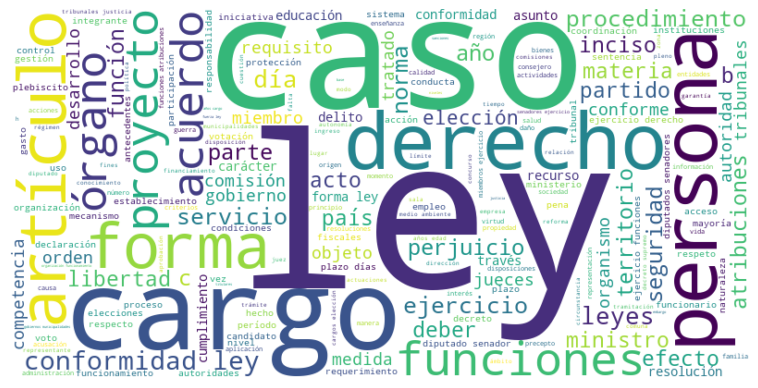

In [21]:
# Función para extraer sustantivos de un texto
def extract_nouns(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if token.pos_ == 'NOUN'])

# Crear WordCloud a partir de la columna 'texto'
def generate_wordcloud(text_column):
    all_text = ' '.join(text_column)
    nouns_text = extract_nouns(all_text)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(nouns_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_wordcloud(df['texto'])

Se implementa bigrama utilizando la combinación sustantivo y adjetivo, sin eliminar stopwords y sin lemmatizar.

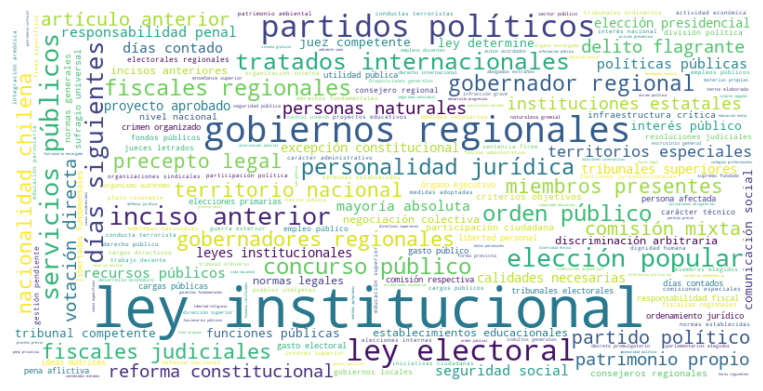

In [22]:
def extract_noun_adj_bigrams(text):
    tokens = word_tokenize(text)
    bi_tokens = [' '.join(x) for x in list(bigrams(tokens))]
    filtered_bigrams = [bi for bi in bi_tokens if is_noun_adj_bigram(bi)]
    
    return filtered_bigrams

def is_noun_adj_bigram(bigram):
    doc = nlp(bigram)
    tags = [token.tag_ for token in doc]
    return tags == ['NOUN', 'ADJ']

def generate_wordcloud_from_bigrams(bigram_list):
    bigram_counter = Counter(bigram_list)

    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate_from_frequencies(bigram_counter)

    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Aplicar funciones al DataFrame
df['bigrams'] = df['texto'].apply(extract_noun_adj_bigrams)

# Obtener todos los bigramas en una lista plana
all_bigrams = [bi for sublist in df['bigrams'].tolist() for bi in sublist]

generate_wordcloud_from_bigrams(all_bigrams)

Se implementa trigrama utilizando la combinación sustantivo, adjetivo y sustantivo.

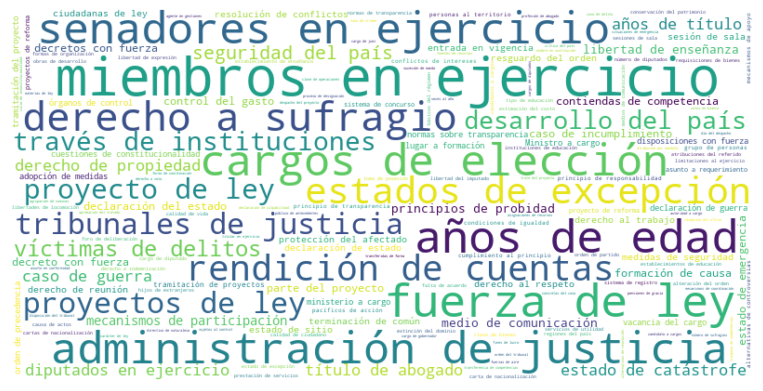

In [23]:
def extract_trigrams_with_tags(text):
    tokens = word_tokenize(text)
    trigram_tokens = list(trigrams(tokens))
    trigrams_with_tags = []

    for tri in trigram_tokens:
        doc = nlp(' '.join(tri))
        tags = [token.tag_ for token in doc]
        
        if tags == ['NOUN', 'ADP', 'NOUN']:
            trigrams_with_tags.append(' '.join(tri))

    return trigrams_with_tags

def generate_wordcloud_from_trigrams(trigram_list):
    trigram_counter = Counter(trigram_list)

    if len(trigram_counter) > 0:
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate_from_frequencies(trigram_counter)
        plt.figure(figsize=(10, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    else:
        print("No se encontraron trigramas para mostrar.")

# Aplicar funciones al DataFrame
df['trigrams_with_tags'] = df['texto'].apply(extract_trigrams_with_tags)

# Obtener todos los trigramas con las etiquetas especificadas
all_trigrams_with_tags = [tri for sublist in df['trigrams_with_tags'].tolist() for tri in sublist]

generate_wordcloud_from_trigrams(all_trigrams_with_tags)

A continuación de implementa un wordcloud por cada capítulo del texto, utilzando solo sustantivos.

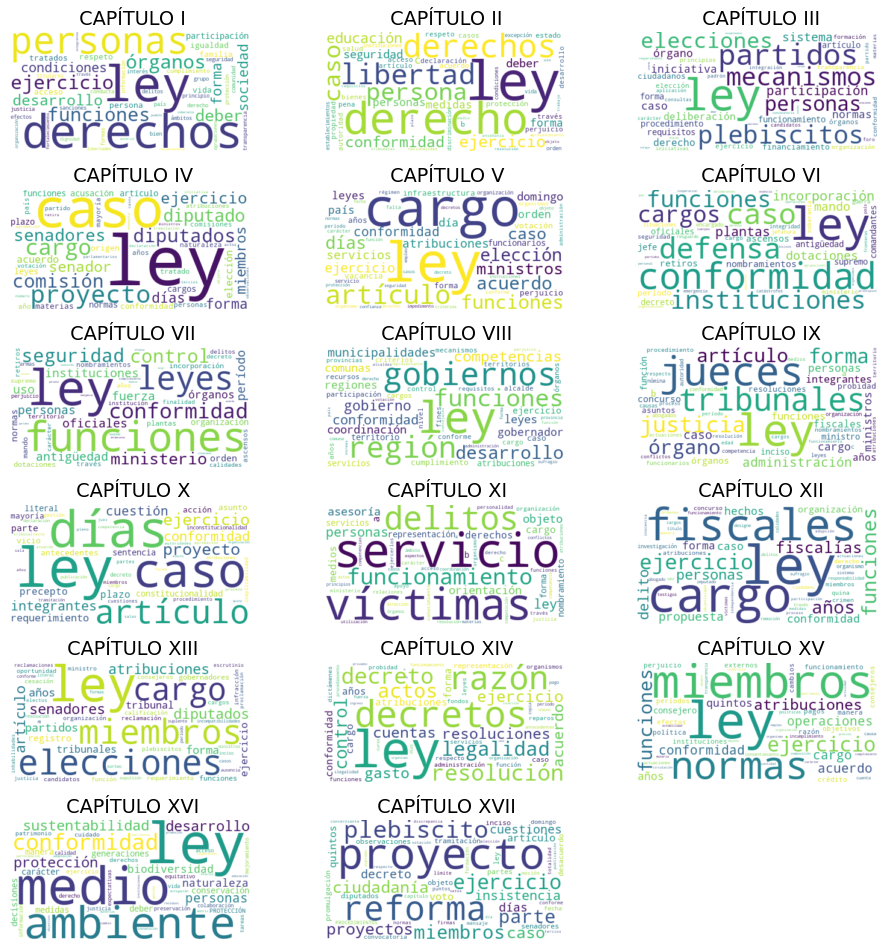

In [24]:
# Función para extraer sustantivos de un texto
def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']

    return nouns

def generate_wordcloud_for_chapters(df):
    chapters = df['capitulo'].unique()

    num_cols = 3  
    num_rows = len(chapters) // num_cols + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    axes = axes.flatten()

    for i, chapter in enumerate(chapters):
        chapter_df = df[df['capitulo'] == chapter]

        all_nouns = [noun for text in chapter_df['texto'] for noun in extract_nouns(text)]

        noun_counter = Counter(all_nouns)

        wc = WordCloud(width=400, height=200, background_color='white', max_words=50).generate_from_frequencies(noun_counter)
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f' {chapter}')
        
    axes[17].remove()

    plt.tight_layout()
    plt.show()
    
generate_wordcloud_for_chapters(df)

A continuación, se quiere generar un resumen por cada artículo utilizando la librería Transformers que contiene modelos pre entrenados.

In [25]:
# Función de preprocesamiento para ingresar a modelo
def prepare_text(text):
    # Eliminar los espacios y los puntos al inicio del texto
    text = re.sub(r'^[.\s]+', '', text)
    # Eliminar palabras con dos o más letras en mayúscula
    text_no_uppercase = re.sub(r'\b[A-ZÁÉÍÓÚÜ]{2,}\b', '', text)
    # Eliminar todas las 'Y' mayúsculas
    text_no_Y = re.sub(r'Y', '', text_no_uppercase)
    # Eliminar los números
    text_no_numbers = re.sub(r'\d+', '', text_no_Y)
    return text_no_numbers

In [26]:
# Aplicar la función de limpieza al texto del dataframe
df['texto_limpio'] = df['texto'].apply(prepare_text)

El objetivo es implementar un sistema de generación de resúmenes de texto utilizando un modelo preentrenado y optimizar sus hiperparámetros mediante la biblioteca Optuna. Se selecciona aleatoriamente el 10% de los datos para reducir el costo computacional. Luego, se carga un modelo y un tokenizador preentrenados específicos para la generación de resúmenes en español. La generación de resúmenes se realiza mediante una función que divide el texto en segmentos, genera resúmenes para cada segmento y los concatena. La similitud del coseno entre el texto original y el resumen se calcula utilizando otra función. El espacio de búsqueda para los hiperparámetros se define y se utiliza Optuna para encontrar la combinación óptima, evaluando la similitud promedio del coseno en un subconjunto de datos. La función objetivo maneja excepciones y devuelve un valor grande si ocurre un error durante la generación de resúmenes, esto evita que un error en un solo caso afecte demasiado la optimización.




El modelo utilizado, "bert2bert_shared-spanish-finetuned-summarization" es una adaptación de BERT para tareas de resumen de texto específicamente en español. BERT (Bidirectional Encoder Representations from Transformers) es un modelo de lenguaje desarrollado por Google que ha demostrado ser efectivo en una variedad de tareas de procesamiento del lenguaje natural.

In [8]:
# Muestra aleatoria del 10% de los datos debido al costo computacional
df_sample = df.sample(frac=0.1, random_state=23)

# Cargar el modelo y el tokenizador
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/bert2bert_shared-spanish-finetuned-summarization")
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert2bert_shared-spanish-finetuned-summarization")

# Función para generar el resumen
def summarize(text, max_length, min_length, no_repeat_ngram_size, num_beams, early_stopping):
    # Dividir el texto en segmentos
    max_segment_length = 512 
    segments = [text[i:i + max_segment_length] for i in range(0, len(text), max_segment_length)]

    # Resumen para cada segmento y concatenarlos
    summaries = []
    for segment in segments:
        input_ids = tokenizer.encode(segment, return_tensors="pt", add_special_tokens=True)
        output_ids = model.generate(input_ids, max_length=max_length, min_length=min_length,
                                    no_repeat_ngram_size=no_repeat_ngram_size, num_beams=num_beams,
                                    early_stopping=early_stopping)
        summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        summaries.append(summary)

    # Concatenar los resúmenes de los segmentos
    full_summary = ". ".join(summaries)
    return full_summary

# Función para calcular la métrica de similitud del coseno entre el texto original y el resumen
def cosine_similarity_score(text, summary):
    # Convertir el texto y el resumen en matrices de características
    text_features = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)
    summary_features = tokenizer.encode(summary, return_tensors="pt", add_special_tokens=True)
    # Calcular la similitud del coseno entre las matrices
    similarity_matrix = cosine_similarity(text_features, summary_features)
    # Devolver el primer elemento de la matriz, que es la similitud entre el texto y el resumen
    return similarity_matrix[0][0]

# Definir el espacio de búsqueda de los parámetros que quieres optimizar
search_space = {
    'max_length': (50, 300),
    'min_length': (10, 30),
    'no_repeat_ngram_size': (2, 4),
    'num_beams': (2, 6),
    'early_stopping': [True, False]}

def objective(trial):
    max_length = trial.suggest_int('max_length', 50, 300)
    min_length = trial.suggest_int('min_length', 5, 50)
    no_repeat_ngram_size = trial.suggest_int('no_repeat_ngram_size', 2, 5)
    num_beams = trial.suggest_int('num_beams', 1, 4)
    early_stopping = trial.suggest_categorical('early_stopping', [True, False])

    try:
        df_sample["resumen_temp"] = df_sample["texto_limpio"].apply(lambda x: summarize(x, max_length=max_length, 
                                                                                        min_length=min_length, 
                                                                                        no_repeat_ngram_size=no_repeat_ngram_size, 
                                                                                        num_beams=num_beams, 
                                                                                        early_stopping=early_stopping))
        
        avg_similarity_score = df_sample.apply(lambda row: cosine_similarity_score(row["texto"], row["resumen_temp"]), axis=1).mean()

        return avg_similarity_score
    except Exception as e:
        # Return a large value for the objective if an exception occurs
        return 1000.0

# Crear el objeto de optimización bayesiana
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Obtener los mejores parámetros encontrados
best_params = study.best_params
print("Mejores parámetros:", best_params)

The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
[I 2024-01-12 15:57:25,811] A new study created in memory with name: no-name-00c696dc-c248-4805-927b-b815d5588ece
[I 2024-01-12 16:01:39,014] Trial 0 finished with value: 1000.0 and parameters: {'max_length': 248, 'min_length': 39, 'no_repeat_ngram_size': 4, 'num_beams': 1, 'early_stopping': True}. Best is trial 0 with value: 1000.0.
[I 2024-01-12 16:07:55,813] Trial 1 finished with value: 1000.0 and parameters: {'max_length': 267, 'min_length': 32, 'no_repeat_ngram_size': 5, 'num_beams': 4, 'early_stopping': True}. Best is trial 0 with value: 1000.0.
[I 2024-01-12 16:13:17,992] Trial 2 finished with value: 1000.0 and parameters: {'max_length': 233, 'min_length': 28, 'no_repeat_ngram_size': 2, 'num_beams': 3, 'early_stopping': True}. Best is trial 0 with value: 1000.0.
[I 2024-01-12 16:18:14,348] Trial 3 finished with value: 1000.0 and pa

Mejores parámetros: {'max_length': 248, 'min_length': 39, 'no_repeat_ngram_size': 4, 'num_beams': 1, 'early_stopping': True}


In [28]:
# Cargar el modelo y el tokenizador
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/bert2bert_shared-spanish-finetuned-summarization")
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert2bert_shared-spanish-finetuned-summarization")

# Definir la función de resumen
def summarize(text):
    # Dividir el texto en segmentos
    max_segment_length = 512 
    segments = [text[i:i + max_segment_length] for i in range(0, len(text), max_segment_length)]

    # Generar resumen para cada segmento
    summaries = []
    for segment in segments:
        input_ids = tokenizer.encode(segment, return_tensors="pt", add_special_tokens=True)
        output_ids = model.generate(input_ids, max_length=248, min_length=39, 
                                    no_repeat_ngram_size=4, num_beams=1, early_stopping=True)
        summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        summaries.append(summary)

    # Concatenar los resúmenes de los segmentos
    full_summary = ". ".join(summaries)
    return full_summary

# Aplicar la función de resumen a cada artículo del dataframe
df["resumen"] = df["texto_limpio"].apply(summarize)

The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


In [31]:
df.resumen[32]

'El presidente de la República, que deberá decidir el estado de emergencia, deberá recurrir el acuerdo del Congreso para que el presidente de la república pueda prorrogarlo por igual período. El acuerdo se tramita en el Congreso. El presidente de la República deberá explicar el estado de emergencia, las zonas en las que se podrá restringir las libertades de locomoción y reunión de los ciudadanos. El presidente de República deberá explicar su decisión'